<h2>School Project 3.4 - For educational purpose only</h2>
<h2>READ ME</h2>
<h3>Complete version of the project with the answers to the questions was sent on January 26th, 2021 through Slack</h3>

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
mpl.style.use('seaborn')

In [2]:
#Data
df_covid1 = pd.read_csv('https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv')
dic_covid1 = pd.read_csv('https://health-infobase.canada.ca/src/data/covidLive/covid19-data-dictionary.csv')
df_covid2 = pd.read_csv('data/COVID19-eng.csv')

In [3]:
#Data cleaning
#Data set 1
df_qc1 = df_covid1.loc[df_covid1['prname'] == 'Quebec'].drop_duplicates().copy()
df_qc1['date'] = pd.to_datetime(df_qc1['date'])
df_qc1 = df_qc1.set_index('date', drop = True)

#Remove outliers based on graph
outliers = ['2020-05-03', '2020-12-25', '2020-12-26']
df_qc1 = df_qc1[~df_qc1.index.isin(outliers)]

#Data set 2
df_qc2 = df_covid2[df_covid2['Region'] == 2].drop_duplicates().copy()


In [4]:
def shift_data_backward(ndays, data):
    '''
    Input:
    ndays : Number of days to shift the data back in time
    data : Dataframe holding the data to shift back in time by ndays
    
    '''
    
    df = data.copy()
    ndays_str = str(ndays) + 'days'
    td = pd.Timedelta(ndays_str)
    
    ref_date = df.index[0]
    start = ref_date - td
    start_str = f'{start.year}-{start.month}-{start.day}'
    time_series = pd.date_range(start=start_str, periods=ndays)

    df_temp = pd.DataFrame({df.columns[0] : np.zeros(ndays)})
    df_temp = df_temp.set_index(time_series)
    df = pd.concat([df_temp, df])
    
    periods = -ndays
    df = df.shift(periods=periods).dropna()
    return df
    

In [5]:
def set_pre_discontinuity_values(x, cutoff):
    if type(cutoff) == str:
        cutoff = pd.to_datetime(cutoff)
    if x<= cutoff:
        x = 0
    else:
        x = 1
    return x


In [6]:
def set_column_cumul_days(data): 
    df = data.copy()
    df_temp=pd.DataFrame({'date' : df['date']})
    df_temp['date_shift'] = df_temp['date'].map(lambda x: x).shift(periods = 1)
    df_temp['ndays'] = df_temp['date'] - df_temp['date_shift']
    df_temp['ndays'] = df_temp['ndays'].map(lambda x: x.days)
    df_temp['cumul_ndays'] = np.cumsum(df_temp['ndays'])
    df_temp.iat[0, -1] = 0
    df = pd.merge(df,  df_temp[['date','cumul_ndays']], left_on = 'date', right_on = 'date').set_index('date')
    df['date'] = df.index.map(lambda x : x)
    return df


In [7]:
def create_model(cutoff, y, X, graph_info, one_feature = False, feature = None, cov_type = False):
    '''
    y : Dataframe of the dependent variable
    X : Dataframe of independent variables (i.e. features)
    graph_info : dictionary of data used to generate the graph
    one_feature : If True, there is only one feature considered in the model. If False, there is more than one feature to
    consider in the model.
    feature : If one_feature is True then input the column name of the variable in the dataframe.
    cov_type : If true, cov_type = 'HC2' to account for heteroscedasticity.
    '''
    y = y.copy()
    X = X.copy()

    x_var_name = feature
    y_var_name = y.columns[0]
    
    if cov_type:
        est = sm.OLS(y, X).fit(cov_type='HC2')          
    else:
        est = sm.OLS(y, X).fit()   

    #Graph
    fig, ax = plt.subplots(figsize = (16,8))
    
    if type(cutoff) == str:
        cutoff = pd.to_datetime(cutoff)
        n_days_ticks = str(int(len(X)/20))
        x_ticks = X.resample(n_days_ticks+'D').mean()
        x_ticks_labels = list(x_ticks.index.map(lambda x: x.strftime('%Y-%m-%d')))
        ax.set_xticks(x_ticks.index)
        ax.set_xticklabels(x_ticks_labels, rotation = 45 , ha= 'right')
        
    if one_feature == 1:
        xfit = np.array(X)
        yfit = est.predict(xfit[:, np.newaxis])
        

        ax.scatter(X.index, y, alpha = 0.5)
        ax.plot(X.index, yfit, color = 'red')
        ax.axvline(x=cutoff, color = 'gray', ls = '--', alpha = 0.9)
        
        ax.set_title(graph_info['title'].title())
        ax.set_xlabel(graph_info['x_label'].title())
        ax.set_ylabel(graph_info['y_label'].title())
        plt.show()
        
    fig = plt.subplots(figsize = (16,8))
    plt.hist(est.resid, bins=30)
    plt.title(f'Histogram of residuals'.title())
    plt.xlabel('Errors')
    plt.ylabel('Count')
    plt.show()    
    print(est.summary())


In [8]:
def create_linear_regression(scenario):
    '''
    Input: Scenario from dictionary of scenarios.
    '''
    scenario_id  = scenario['sc_id']
    scenario_num = int(scenario_id.split('_')[-1])
    data = scenario['data'].copy()
    start = scenario['start']
    end = scenario['end']
    ndays_shift = scenario['ndays_shift']
    cutoff = scenario['cutoff']
    model_type = scenario['model_type']
    graph_info = scenario['graph_info']
    
    df = data.copy()
    if scenario_num != 2:
        #Shift data backwards to account for estimated delay between date of publication and day at which person was possibly sick
        df = df[['numtoday']]
        df = shift_data_backward(ndays_shift, df)

        #Set time window for analysis
        df = df.loc[start: end]
        df['date'] = df.index.map(lambda date : date)

        #Set column of cumulative days
        df = set_column_cumul_days(df)
        df = df[['date', 'numtoday', 'cumul_ndays']]

        X = df[['cumul_ndays']].copy()
        X['pre_discontinuity']= X.index.map(lambda x : set_pre_discontinuity_values(x, cutoff))
        X['cumul_ndays_pre_disc']= X['cumul_ndays']*X['pre_discontinuity']
        X = sm.add_constant(X)

        if model_type == 'polynomial':
            X['cumul_ndays_sq']= X['cumul_ndays'].map(lambda x : x**2)
            X['cumul_ndays_sq_pre_disc']= X['cumul_ndays_sq']*X['pre_discontinuity']
            X = X.drop('pre_discontinuity', axis=1)
            
            if scenario_num ==1:
                X = X.drop('cumul_ndays', axis=1)
        
        y = df[['numtoday']]

        create_model(cutoff, y, X, graph_info = graph_info, one_feature = True, feature = 'cumul_ndays', cov_type = True)
    
    elif scenario_num == 2:
        
        df = df[['Episode week','Episode year', 'Age group', 'Occupation']].sort_values('Episode week')
        df = df.groupby('Episode week').count()
        df = df.rename(columns = {'Occupation': 'num_cases_weekly'})
        df = df.loc[df.index != 99]
        df = df[['num_cases_weekly']]
        df = df.loc[(df.index >= start) & (df.index < end )]
        df['Episode week'] = df.index.map(lambda x: x)

        X = df[['Episode week']].copy()
        X['pre_discontinuity']= X.index.map(lambda x : set_pre_discontinuity_values(x, cutoff))
        X['ep_week_pre_disc']= X['Episode week']*X['pre_discontinuity']
        X = sm.add_constant(X)

        y = df[['num_cases_weekly']]

        create_model(cutoff, y, X, graph_info, one_feature = True, feature = 'Episode week', cov_type = True)



In [9]:
#Array of dictionaries to store data for each scenarios
scenarios = [
    
     {
        'sc_id': 'polynomial_1',
        'data' : df_qc1,
        'start' : '2020-02-27',
        'end' : '2020-04-15',
        'ndays_shift' : 14,
        'cutoff' : '2020-03-20',
        'model_type' : 'polynomial',
        'graph_info' : {
                        'title' : 'Figure 1 : Scenario 1 - Number of New Daily COVID-19 Cases Over Time - Second Degree Polynomial Regression',
                        'x_label' : 'Date',
                        'y_label' : 'Number of New Daily COVID-19 Cases',
                        }
     },
    {
        'sc_id' : 'linear_1',
        'data' : df_qc1,
        'start': '2020-02-27',
        'end' : '2020-04-15',
        'ndays_shift' : 14,
        'cutoff' : '2020-03-20',
        'model_type' : 'linear',
        'graph_info': {
                        'title' : 'Figure 2 : Scenario 1 - Number of New Daily COVID-19 Cases Over Time - Linear Regression',
                        'x_label' : 'Date',
                        'y_label' : 'Number of New Daily COVID-19 Cases',
                        }
    }, 
    
    {
        'sc_id' : 'linear_2',
        'data' : df_qc2,
        'start': 27,
        'end' : 51,
        'ndays_shift' : None,
        'cutoff' : 36,
        'model_type' : 'linear',
        'graph_info': {
                        'title' : 'Figure 3 : Scenario 2 - Number of new Weekly COVID-19 cases in group of people\n aged between 0 and 19 years old or who work in schools and daycares Over Time - Linear Regression',
                        'x_label' : 'Week number starting from first week of 2020',
                        'y_label' : 'Number of new Weekly COVID-19 cases in group of people aged between 0\nand 19 years old or who work in schools and daycares',
                        }
    }, 
     {
        'sc_id': 'polynomial_3',
        'data' : df_qc1,
        'start' : '2020-09-28',
        'end' : '2021-01-15',
        'ndays_shift' : 7,
        'cutoff' : '2020-12-25',
        'model_type' : 'polynomial',
        'graph_info' : {
                        'title' : 'Figure 4: Number of New Daily COVID-19 Cases Over Time - Second Degree Polynomial Regression',
                        'x_label' : 'Date',
                        'y_label' : 'Number of New Daily COVID-19 Cases',
                        }
     },
     {
        'sc_id': 'linear_3',
        'data' : df_qc1,
        'start' : '2020-09-28',
        'end' : '2021-01-15',
        'ndays_shift' : 7,
        'cutoff' : '2020-12-25',
        'model_type' : 'linear',
        'graph_info' : {
                        'title' : 'Figure 5: Scenario 3 - Number of New Daily COVID-19 Cases Over Time - Linear Regression',
                        'x_label' : 'Date',
                        'y_label' : 'Number of New Daily COVID-19 Cases',
                        }
     },
        
]


scenarios = {s['sc_id'] : s for s in scenarios}

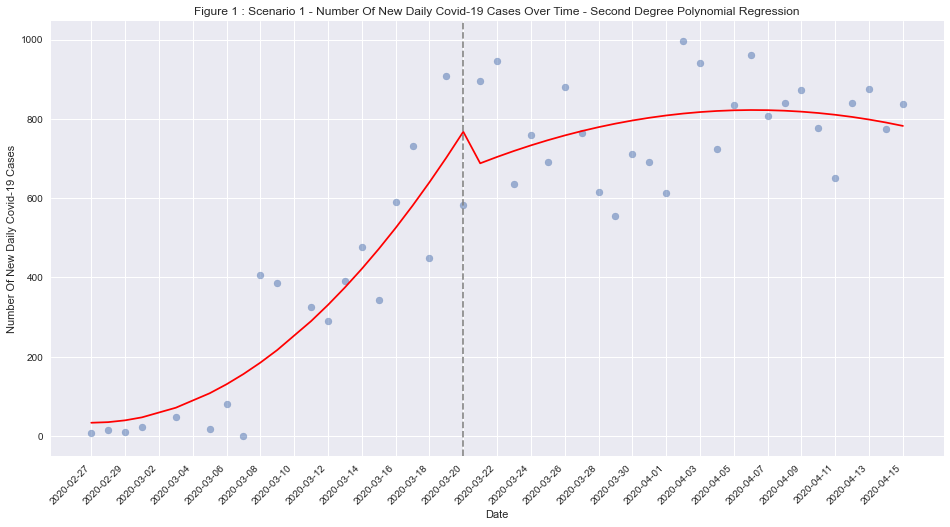

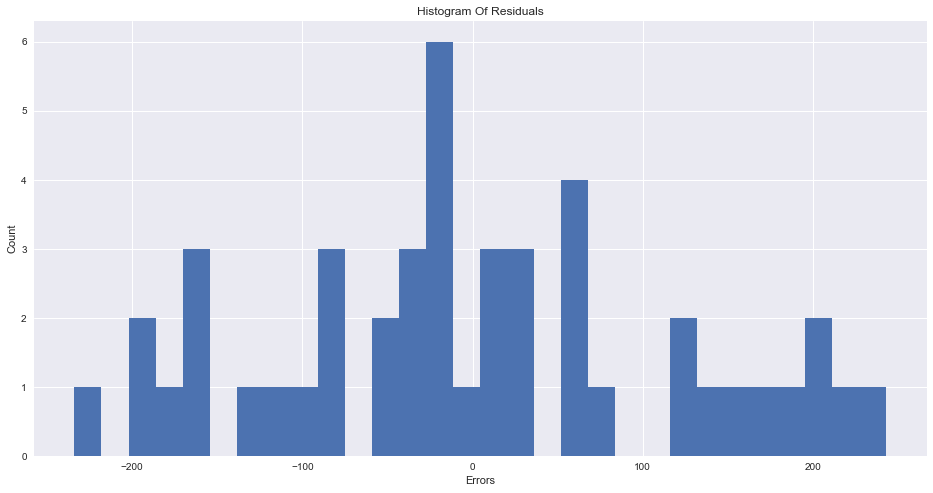

                            OLS Regression Results                            
Dep. Variable:               numtoday   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     131.7
Date:                Mon, 25 Jan 2021   Prob (F-statistic):           2.17e-21
Time:                        20:40:29   Log-Likelihood:                -285.59
No. Observations:                  46   AIC:                             579.2
Df Residuals:                      42   BIC:                             586.5
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [10]:
#Scenario 1 - Polynomial Regression
create_linear_regression(scenarios['polynomial_1'])

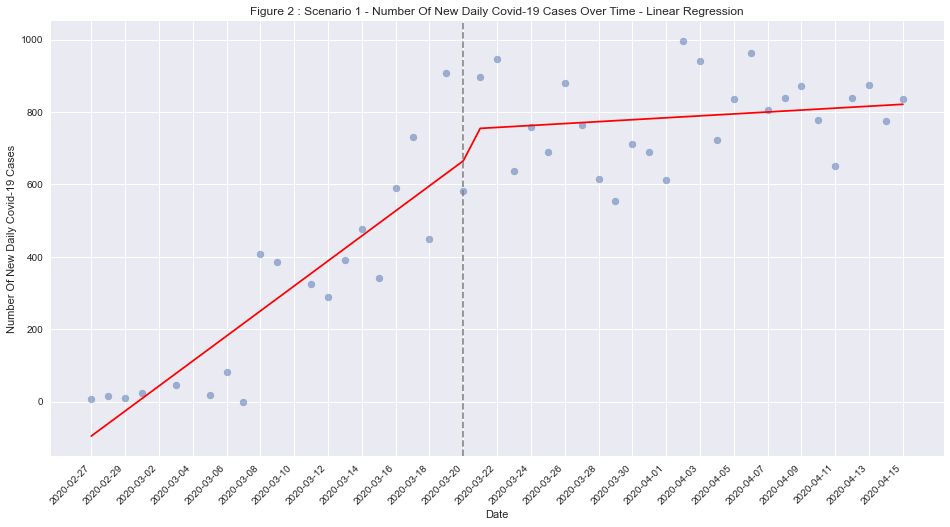

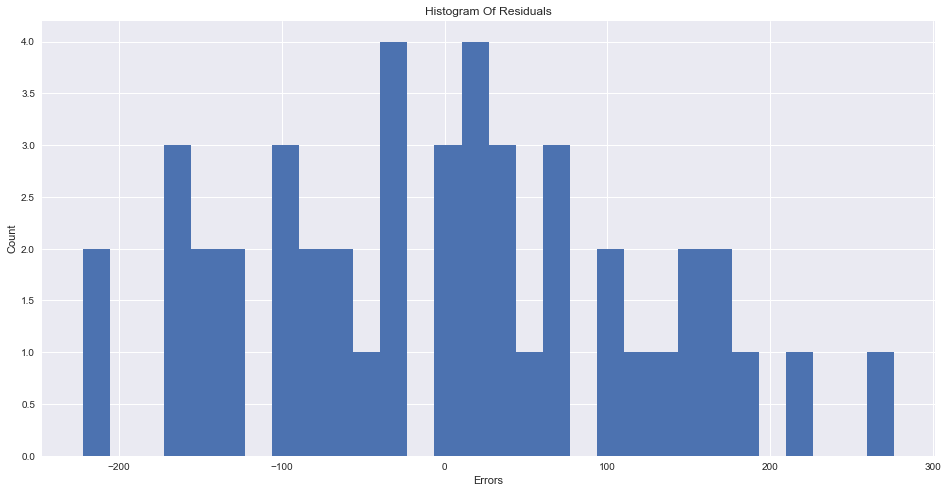

                            OLS Regression Results                            
Dep. Variable:               numtoday   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     124.3
Date:                Mon, 25 Jan 2021   Prob (F-statistic):           6.45e-21
Time:                        20:40:30   Log-Likelihood:                -284.86
No. Observations:                  46   AIC:                             577.7
Df Residuals:                      42   BIC:                             585.0
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -94.8708 

In [11]:
#Scenario 1 - Linear regression
create_linear_regression(scenarios['linear_1'])

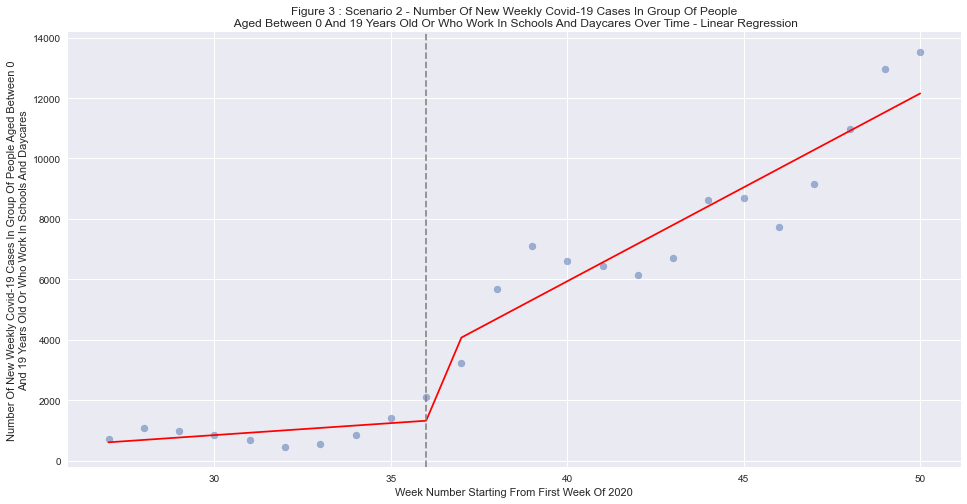

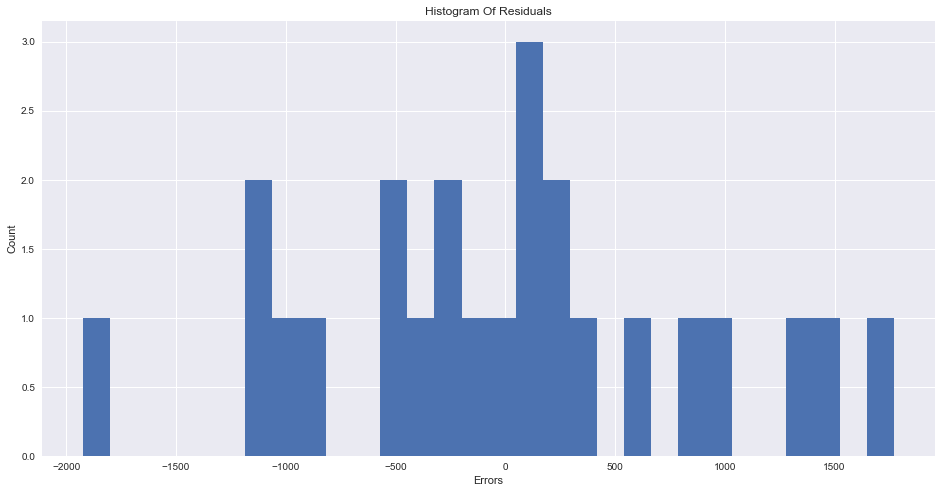

                            OLS Regression Results                            
Dep. Variable:       num_cases_weekly   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     160.3
Date:                Mon, 25 Jan 2021   Prob (F-statistic):           3.74e-14
Time:                        20:40:30   Log-Likelihood:                -196.59
No. Observations:                  24   AIC:                             401.2
Df Residuals:                      20   BIC:                             405.9
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1534.0000   1810.83

In [12]:
#Scenario 2 - Linear Regression
create_linear_regression(scenarios['linear_2'])

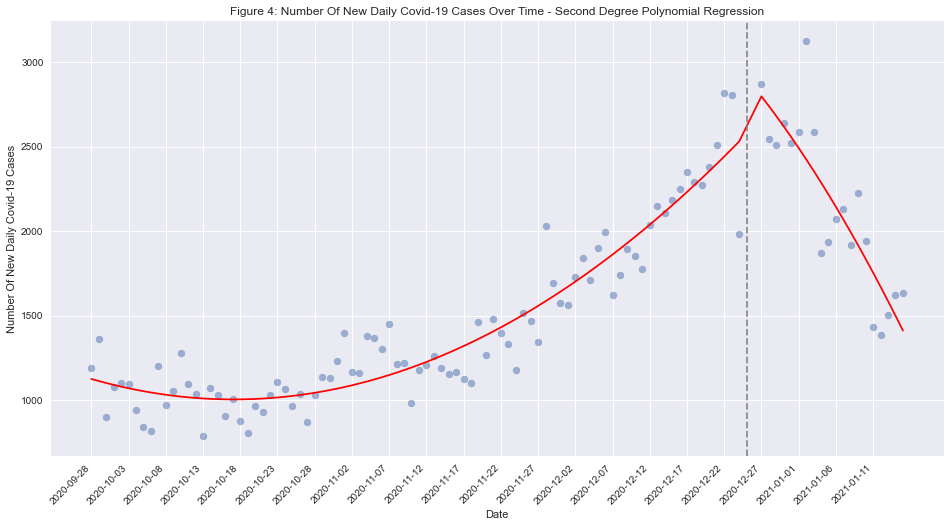

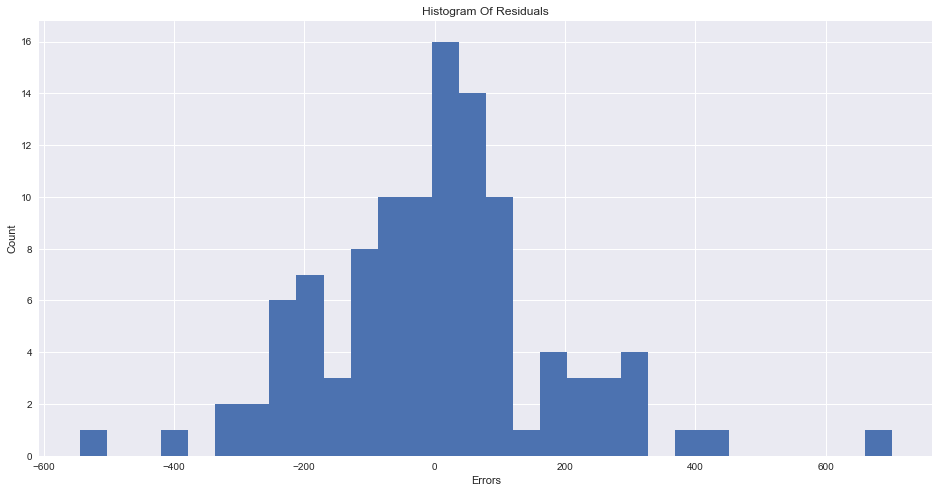

                            OLS Regression Results                            
Dep. Variable:               numtoday   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     165.0
Date:                Mon, 25 Jan 2021   Prob (F-statistic):           7.31e-44
Time:                        20:40:31   Log-Likelihood:                -714.58
No. Observations:                 108   AIC:                             1439.
Df Residuals:                     103   BIC:                             1453.
Df Model:                           4                                         
Covariance Type:                  HC2                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

In [13]:
#Scenario 3 - Polynomial Regression
create_linear_regression(scenarios['polynomial_3'])


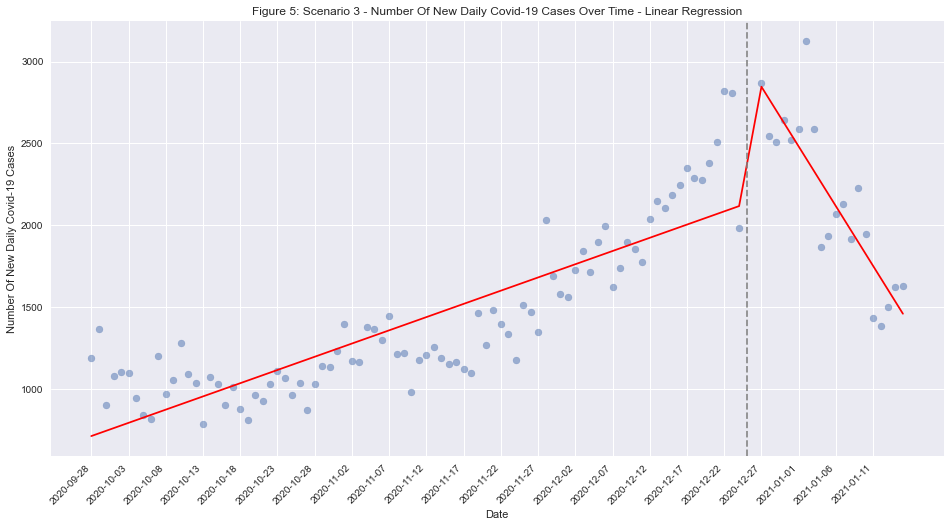

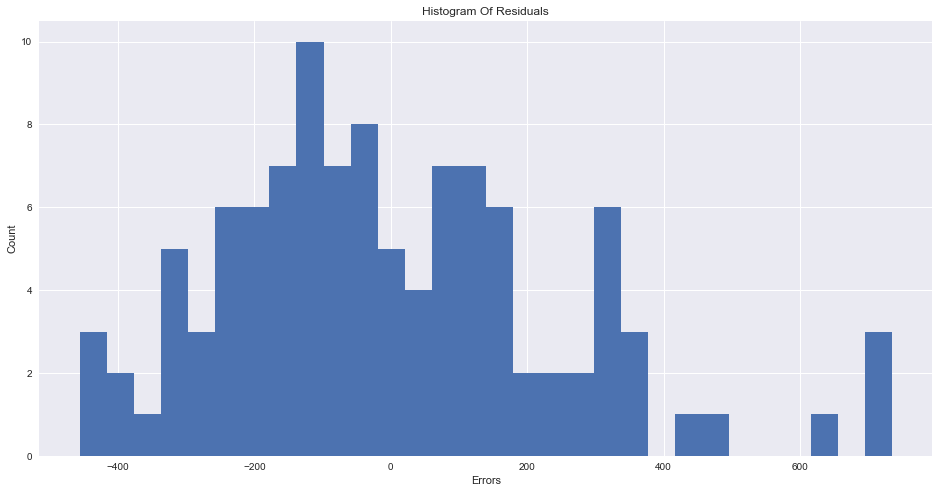

                            OLS Regression Results                            
Dep. Variable:               numtoday   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     118.6
Date:                Mon, 25 Jan 2021   Prob (F-statistic):           1.96e-33
Time:                        20:40:31   Log-Likelihood:                -749.62
No. Observations:                 108   AIC:                             1507.
Df Residuals:                     104   BIC:                             1518.
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  712.1504 

In [14]:
#Scenario 3 - Linear Regression
create_linear_regression(scenarios['linear_3'])
